### Data Dictionary

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer
from feature_engine import outlier_removers as outr

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [3]:
df = pd.read_csv("bronxclassif.csv")

In [4]:
df

,ComplaintType,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
0,HEAT/HOT WATER,2340,46.0,0.90,5.0,6.5,1,15000,200.0,1,2.0,2628,2000,6.02,2458,1935,2000,65,85
1,OTHERS,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1.0,272,2000,6.02,2458,1931,1994,63,89
2,HEAT/HOT WATER,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2.0,2628,2000,6.02,2458,1931,2000,69,89
3,HEAT/HOT WATER,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5.0,2628,12500,6.02,2458,1931,2001,70,89
4,HEAT/HOT WATER,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,5.0,2628,6876,6.02,1719,1920,2009,89,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89849,HEAT/HOT WATER,2340,46.0,0.90,2.0,2.0,100,2513,100.0,1,2.0,2628,2000,1.25,2458,1935,2000,65,85
89850,OTHERS,2340,46.0,0.90,3.4,6.5,150,2513,100.0,1,2.0,2628,2000,6.02,2458,1935,2000,65,85
89851,HEAT/HOT WATER,2340,46.0,0.90,2.0,2.0,200,2513,100.0,1,2.0,2628,2000,1.25,2458,1935,2000,65,85
89852,OTHERS,2340,46.0,0.90,2.0,2.0,8900,2513,100.0,1,2.0,2628,2000,1.25,2458,1935,2000,65,85


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89854 entries, 0 to 89853
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ComplaintType  89854 non-null  object 
 1   BldgArea       89854 non-null  int64  
 2   BldgDepth      89854 non-null  float64
 3   BuiltFAR       89854 non-null  float64
 4   CommFAR        89854 non-null  float64
 5   FacilFAR       89854 non-null  float64
 6   Lot            89854 non-null  int64  
 7   LotArea        89854 non-null  int64  
 8   LotDepth       89854 non-null  float64
 9   NumBldgs       89854 non-null  int64  
 10  NumFloors      89854 non-null  float64
 11  OfficeArea     89854 non-null  int64  
 12  ResArea        89854 non-null  int64  
 13  ResidFAR       89854 non-null  float64
 14  RetailArea     89854 non-null  int64  
 15  YearBuilt      89854 non-null  int64  
 16  YearAlter1     89854 non-null  int64  
 17  Age            89854 non-null  int64  
 18  Period

In [6]:
df.describe(include='all')

,ComplaintType,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
count,89854,8.985400e+04,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,8.985400e+04,89854.000000,89854.000000,89854.000000,8.985400e+04,8.985400e+04,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000
unique,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,HEAT/HOT WATER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,33740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.280879e+03,51.652695,1.172450,1.996515,2.878297,111.493601,1.024746e+04,106.266331,1.252343,2.419035,3.059572e+03,6.043332e+03,1.735470,2646.738376,1942.808078,1999.816124,57.008046,77.191922
std,NaN,6.518636e+04,28.237084,1.773936,0.304805,1.576991,467.387099,3.058250e+05,73.727413,1.904116,1.355107,1.186597e+04,5.657408e+04,1.258452,4783.403278,28.775661,3.958911,28.822516,28.775661
min,NaN,1.000000e+00,2.000000,0.010000,0.500000,1.000000,1.000000,1.000000e+00,0.080000,1.000000,0.500000,5.000000e+01,1.000000e+02,0.500000,100.000000,1780.000000,1905.000000,-91.000000,3.000000
25%,NaN,1.771000e+03,36.000000,0.640000,2.000000,2.000000,20.000000,2.200000e+03,95.000000,1.000000,2.000000,2.628000e+03,1.482000e+03,0.900000,2458.000000,1925.000000,2000.000000,40.000000,60.000000
50%,NaN,2.340000e+03,46.000000,0.900000,2.000000,2.000000,41.000000,2.513000e+03,100.000000,1.000000,2.000000,2.628000e+03,2.000000e+03,1.250000,2458.000000,1935.000000,2000.000000,65.000000,85.000000
75%,NaN,3.288000e+03,55.000000,1.250000,2.000000,4.800000,73.000000,4.250000e+03,102.420000,1.000000,3.000000,2.628000e+03,2.616000e+03,2.430000,2458.000000,1960.000000,2000.000000,75.000000,95.000000


In [7]:
df.shape

(89854, 19)

In [8]:
df.columns

Index(['ComplaintType', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
       'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors',
       'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt',
       'YearAlter1', 'Age', 'Period'],
      dtype='object')

In [9]:
df['ComplaintType'].value_counts()

HEAT/HOT WATER          33740
OTHERS                  27328
PAINT/PLASTER           10830
PLUMBING                10080
UNSANITARY CONDITION     7876
Name: ComplaintType, dtype: int64

### Data Visualization

### Univariate Data Exploration

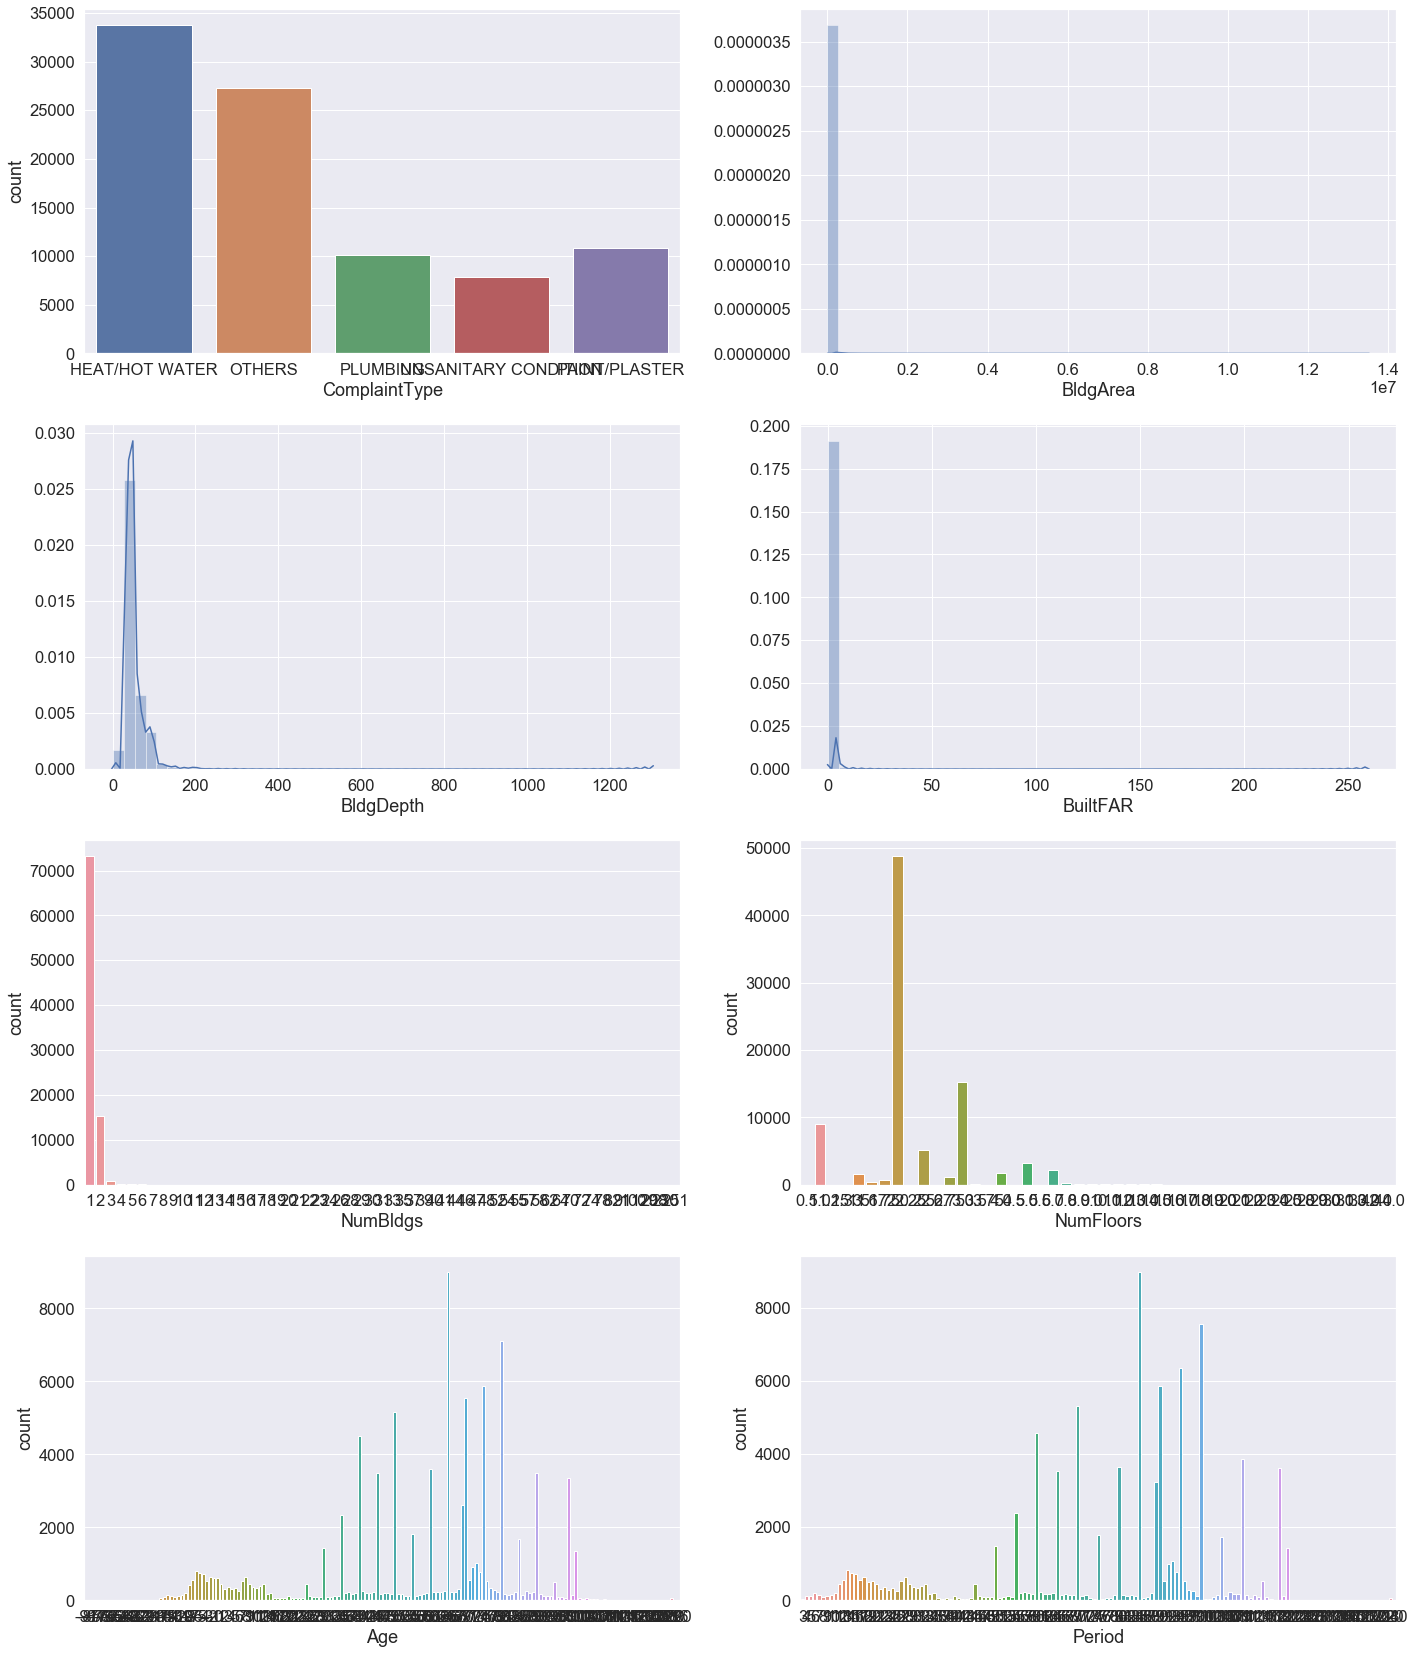

In [11]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.ComplaintType)
plt.subplot(7,2,2)
sns.distplot(df.BldgArea)
plt.subplot(7,2,3)
sns.distplot(df.BldgDepth)
plt.subplot(7,2,4)
sns.distplot(df.BuiltFAR)
plt.subplot(7,2,5)
sns.countplot(df.NumBldgs)
plt.subplot(7,2,6)
sns.countplot(df.NumFloors)
plt.subplot(7,2,7)
sns.countplot(df.Age)
plt.subplot(7,2,8)
sns.countplot(df.Period)
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [12]:
df.corr()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
BldgArea,1.000000,0.271543,0.282024,0.018612,0.097995,0.073958,0.167208,0.228764,0.539628,0.378734,0.228200,0.892606,0.095588,0.163924,0.025321,-0.026497,-0.028919,-0.025321
BldgDepth,0.271543,1.000000,0.253098,0.033343,0.327453,0.020118,0.038944,0.265244,0.037716,0.306998,0.201347,0.152695,0.303264,0.190891,-0.013378,-0.122657,-0.003492,0.013378
BuiltFAR,0.282024,0.253098,1.000000,0.045311,0.261933,0.104422,-0.001190,-0.004860,0.073646,0.431553,0.039198,0.273558,0.274143,0.334664,-0.002818,-0.071441,-0.006999,0.002818
CommFAR,0.018612,0.033343,0.045311,1.000000,0.201879,-0.004482,-0.003201,-0.018449,-0.004746,0.053952,0.024376,0.005432,0.205692,0.070762,-0.025981,-0.007157,0.024956,0.025981
FacilFAR,0.097995,0.327453,0.261933,0.201879,1.000000,-0.021882,-0.000955,0.009658,-0.027673,0.315522,0.039028,0.084061,0.886227,0.051716,-0.048940,-0.080600,0.037790,0.048940
Lot,0.073958,0.020118,0.104422,-0.004482,-0.021882,1.000000,0.007123,0.047337,0.096926,0.115909,0.017454,0.068253,-0.006645,0.072149,0.075619,0.017478,-0.073095,-0.075619
LotArea,0.167208,0.038944,-0.001190,-0.003201,-0.000955,0.007123,1.000000,0.313215,0.331919,0.027789,0.075531,0.072371,-0.001610,0.014589,0.001418,-0.007223,-0.002407,-0.001418
LotDepth,0.228764,0.265244,-0.004860,-0.018449,0.009658,0.047337,0.313215,1.000000,0.200114,0.102525,0.158111,0.132014,0.003171,0.092281,0.015179,-0.023676,-0.018406,-0.015179
NumBldgs,0.539628,0.037716,0.073646,-0.004746,-0.027673,0.096926,0.331919,0.200114,1.000000,0.051071,0.068157,0.453766,-0.033752,0.048823,-0.033202,0.007246,0.034144,0.033202
NumFloors,0.378734,0.306998,0.431553,0.053952,0.315522,0.115909,0.027789,0.102525,0.051071,1.000000,0.070381,0.382163,0.349169,0.013989,0.071177,-0.082832,-0.082439,-0.071177


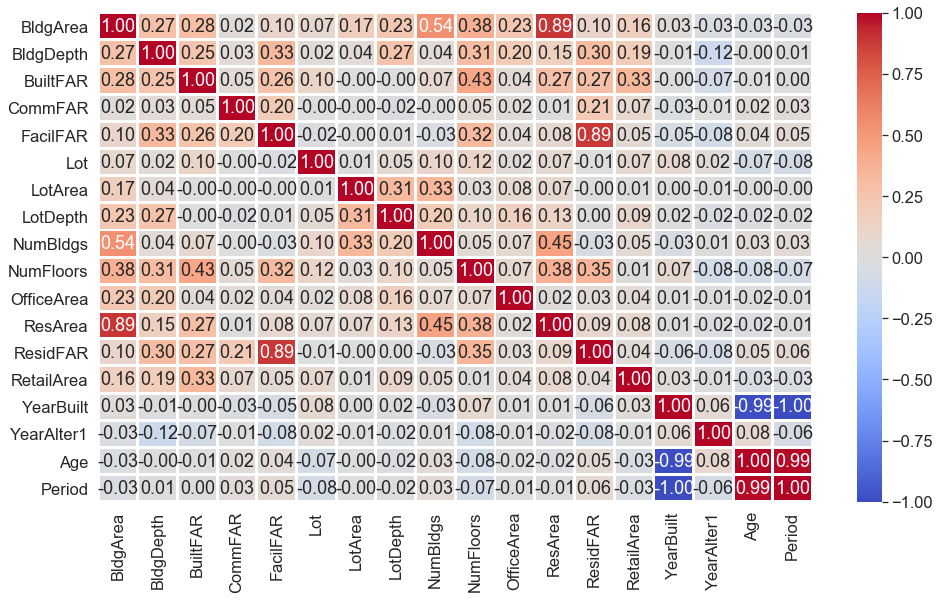

In [13]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

In [15]:
# sns.pairplot(df)
# plt.show()

### Data Preprocessing

### Treat Duplicate Values

In [16]:
df.duplicated(keep='first').sum()

144

In [17]:
df[df.duplicated(keep=False)]

,ComplaintType,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
62,PAINT/PLASTER,2340,46.0,0.9,2.0,4.8,15,4000,100.0,1,2.0,2628,2000,2.43,2458,1935,2000,65,85
167,OTHERS,2340,46.0,0.9,2.0,4.8,22,2500,100.0,1,2.0,2628,2000,2.43,2458,1935,2000,65,85
256,PAINT/PLASTER,2340,46.0,0.9,2.0,4.8,15,4000,100.0,1,2.0,2628,2000,2.43,2458,1935,2000,65,85
369,HEAT/HOT WATER,2340,46.0,0.9,2.0,4.8,36,2500,100.0,1,2.0,2628,2000,2.43,2458,1935,2000,65,85
373,HEAT/HOT WATER,2340,46.0,0.9,2.0,2.0,51,2500,100.0,1,2.0,2628,2000,1.25,2458,1935,2000,65,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84078,HEAT/HOT WATER,2340,46.0,0.9,2.0,1.0,22,2500,100.0,1,2.0,2628,2000,0.60,2458,1935,2000,65,85
85139,HEAT/HOT WATER,2340,46.0,0.9,2.0,1.0,3,5000,100.0,1,2.0,2628,2000,0.60,2458,1935,2000,65,85
89848,OTHERS,2340,46.0,0.9,2.0,2.0,1,2513,100.0,1,2.0,2628,2000,1.25,2458,1935,2000,65,85
89852,OTHERS,2340,46.0,0.9,2.0,2.0,8900,2513,100.0,1,2.0,2628,2000,1.25,2458,1935,2000,65,85


In [18]:
df.drop_duplicates(keep='first',ignore_index=True, inplace=True)

In [19]:
df

,ComplaintType,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
0,HEAT/HOT WATER,2340,46.0,0.90,5.0,6.5,1,15000,200.0,1,2.0,2628,2000,6.02,2458,1935,2000,65,85
1,OTHERS,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1.0,272,2000,6.02,2458,1931,1994,63,89
2,HEAT/HOT WATER,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2.0,2628,2000,6.02,2458,1931,2000,69,89
3,HEAT/HOT WATER,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5.0,2628,12500,6.02,2458,1931,2001,70,89
4,HEAT/HOT WATER,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,5.0,2628,6876,6.02,1719,1920,2009,89,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89705,HEAT/HOT WATER,2340,46.0,0.90,2.0,2.0,130,323,184.5,1,2.0,2628,2000,0.90,2458,1935,2000,65,85
89706,PLUMBING,2340,46.0,0.90,2.0,2.0,135,2513,126.0,1,2.0,2628,2000,0.90,2458,1935,2000,65,85
89707,HEAT/HOT WATER,2340,46.0,0.90,2.0,2.0,100,2513,100.0,1,2.0,2628,2000,1.25,2458,1935,2000,65,85
89708,OTHERS,2340,46.0,0.90,3.4,6.5,150,2513,100.0,1,2.0,2628,2000,6.02,2458,1935,2000,65,85


### Treat Outliers

In [20]:
df.columns

Index(['ComplaintType', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
       'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors',
       'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt',
       'YearAlter1', 'Age', 'Period'],
      dtype='object')

In [21]:
df.describe()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
count,8.971000e+04,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,8.971000e+04,89710.000000,89710.000000,89710.000000,8.971000e+04,8.971000e+04,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000
mean,8.290448e+03,51.661648,1.172873,1.996554,2.878585,111.410066,1.025970e+04,106.276771,1.252681,2.419596,3.060265e+03,6.049779e+03,1.735898,2647.012997,1942.809965,1999.815829,57.005863,77.190035
std,6.523822e+04,28.256989,1.775319,0.304977,1.577345,465.907453,3.060702e+05,73.786074,1.905609,1.356075,1.187548e+04,5.661924e+04,1.258878,4787.228489,28.789149,3.962080,28.836044,28.789149
min,1.000000e+00,2.000000,0.010000,0.500000,1.000000,1.000000,1.000000e+00,0.080000,1.000000,0.500000,5.000000e+01,1.000000e+02,0.500000,100.000000,1780.000000,1905.000000,-91.000000,3.000000
25%,1.770000e+03,36.000000,0.640000,2.000000,2.000000,20.000000,2.200000e+03,95.000000,1.000000,2.000000,2.628000e+03,1.482000e+03,0.900000,2458.000000,1925.000000,2000.000000,40.000000,60.000000
50%,2.340000e+03,46.000000,0.900000,2.000000,2.000000,41.000000,2.513000e+03,100.000000,1.000000,2.000000,2.628000e+03,2.000000e+03,1.250000,2458.000000,1935.000000,2000.000000,65.000000,85.000000
75%,3.292000e+03,55.000000,1.250000,2.000000,4.800000,73.000000,4.250000e+03,102.500000,1.000000,3.000000,2.628000e+03,2.620000e+03,2.430000,2458.000000,1960.000000,2000.000000,75.000000,95.000000
max,1.354011e+07,1300.000000,259.800000,9.000000,10.000000,9978.000000,7.425000e+07,8000.000000,251.000000,44.000000,1.311800e+06,1.321140e+07,10.000000,598908.000000,2017.000000,2017.000000,220.000000,240.000000


In [22]:
windsorizer = Winsorizer(distribution='skewed',tail='right',fold=3.0,
                         variables=None)

In [23]:
windsorizer.fit(df)

Winsorizer(distribution='skewed', fold=3.0, tail='right',
           variables=['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
                      'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs',
                      'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR',
                      'RetailArea', 'YearBuilt', 'YearAlter1', 'Age',
                      'Period'])

In [24]:
df2 = windsorizer.transform(df)

In [25]:
df2

,ComplaintType,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
0,HEAT/HOT WATER,2340.0,46.0,0.90,2.0,6.5,1.0,10400.0,125.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,1935.0,2000.0,65.0,85.0
1,OTHERS,752.0,16.0,0.05,2.0,6.5,4.0,10400.0,100.0,1.0,1.0,272.0,2000.0,6.02,2458.0,1931.0,1994.0,63.0,89.0
2,HEAT/HOT WATER,7858.0,112.0,1.13,2.0,6.5,10.0,10400.0,125.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,1931.0,2000.0,69.0,89.0
3,HEAT/HOT WATER,7858.0,85.0,3.08,2.0,6.5,17.0,2500.0,100.0,1.0,5.0,2628.0,6034.0,6.02,2458.0,1931.0,2000.0,70.0,89.0
4,HEAT/HOT WATER,7858.0,70.0,3.08,2.0,6.5,18.0,1875.0,75.0,1.0,5.0,2628.0,6034.0,6.02,1719.0,1920.0,2000.0,89.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89705,HEAT/HOT WATER,2340.0,46.0,0.90,2.0,2.0,130.0,323.0,125.0,1.0,2.0,2628.0,2000.0,0.90,2458.0,1935.0,2000.0,65.0,85.0
89706,PLUMBING,2340.0,46.0,0.90,2.0,2.0,135.0,2513.0,125.0,1.0,2.0,2628.0,2000.0,0.90,2458.0,1935.0,2000.0,65.0,85.0
89707,HEAT/HOT WATER,2340.0,46.0,0.90,2.0,2.0,100.0,2513.0,100.0,1.0,2.0,2628.0,2000.0,1.25,2458.0,1935.0,2000.0,65.0,85.0
89708,OTHERS,2340.0,46.0,0.90,2.0,6.5,150.0,2513.0,100.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,1935.0,2000.0,65.0,85.0


In [26]:
df2.describe()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
count,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,89710.0,89710.00000,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000,89710.000000
mean,3026.516698,50.301186,1.082738,1.969675,2.878585,61.029874,3713.858700,98.240002,1.0,2.37610,2608.307513,2352.026820,1.735022,2419.933530,1942.809965,1999.515361,56.992888,77.177238
std,2017.139832,19.919755,0.711875,0.179463,1.577345,60.579571,2578.046648,16.912932,0.0,1.04469,181.366897,1330.580317,1.254607,228.818611,28.789149,3.536700,28.775888,28.729914
min,1.000000,2.000000,0.010000,0.500000,1.000000,1.000000,1.000000,0.080000,1.0,0.50000,50.000000,100.000000,0.500000,100.000000,1780.000000,1905.000000,-91.000000,3.000000
25%,1770.000000,36.000000,0.640000,2.000000,2.000000,20.000000,2200.000000,95.000000,1.0,2.00000,2628.000000,1482.000000,0.900000,2458.000000,1925.000000,2000.000000,40.000000,60.000000
50%,2340.000000,46.000000,0.900000,2.000000,2.000000,41.000000,2513.000000,100.000000,1.0,2.00000,2628.000000,2000.000000,1.250000,2458.000000,1935.000000,2000.000000,65.000000,85.000000
75%,3292.000000,55.000000,1.250000,2.000000,4.800000,73.000000,4250.000000,102.500000,1.0,3.00000,2628.000000,2620.000000,2.430000,2458.000000,1960.000000,2000.000000,75.000000,95.000000
max,7858.000000,112.000000,3.080000,2.000000,10.000000,232.000000,10400.000000,125.000000,1.0,6.00000,2628.000000,6034.000000,7.020000,2458.000000,2017.000000,2000.000000,180.000000,200.000000


In [27]:
windsorizer.left_tail_caps_

{}

In [28]:
windsorizer.right_tail_caps_

{'BldgArea': 7858.0,
 'BldgDepth': 112.0,
 'BuiltFAR': 3.08,
 'CommFAR': 2.0,
 'FacilFAR': 13.2,
 'Lot': 232.0,
 'LotArea': 10400.0,
 'LotDepth': 125.0,
 'NumBldgs': 1.0,
 'NumFloors': 6.0,
 'OfficeArea': 2628.0,
 'ResArea': 6034.0,
 'ResidFAR': 7.020000000000001,
 'RetailArea': 2458.0,
 'YearBuilt': 2065.0,
 'YearAlter1': 2000.0,
 'Age': 180.0,
 'Period': 200.0}

### Perform One-Hot Encoding

In [29]:
encoder = LabelEncoder()

In [30]:
df2['ComplaintType'] = encoder.fit_transform(df2['ComplaintType'])

In [31]:
df2

,ComplaintType,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Age,Period
0,0,2340.0,46.0,0.90,2.0,6.5,1.0,10400.0,125.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,1935.0,2000.0,65.0,85.0
1,1,752.0,16.0,0.05,2.0,6.5,4.0,10400.0,100.0,1.0,1.0,272.0,2000.0,6.02,2458.0,1931.0,1994.0,63.0,89.0
2,0,7858.0,112.0,1.13,2.0,6.5,10.0,10400.0,125.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,1931.0,2000.0,69.0,89.0
3,0,7858.0,85.0,3.08,2.0,6.5,17.0,2500.0,100.0,1.0,5.0,2628.0,6034.0,6.02,2458.0,1931.0,2000.0,70.0,89.0
4,0,7858.0,70.0,3.08,2.0,6.5,18.0,1875.0,75.0,1.0,5.0,2628.0,6034.0,6.02,1719.0,1920.0,2000.0,89.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89705,0,2340.0,46.0,0.90,2.0,2.0,130.0,323.0,125.0,1.0,2.0,2628.0,2000.0,0.90,2458.0,1935.0,2000.0,65.0,85.0
89706,3,2340.0,46.0,0.90,2.0,2.0,135.0,2513.0,125.0,1.0,2.0,2628.0,2000.0,0.90,2458.0,1935.0,2000.0,65.0,85.0
89707,0,2340.0,46.0,0.90,2.0,2.0,100.0,2513.0,100.0,1.0,2.0,2628.0,2000.0,1.25,2458.0,1935.0,2000.0,65.0,85.0
89708,1,2340.0,46.0,0.90,2.0,6.5,150.0,2513.0,100.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,1935.0,2000.0,65.0,85.0


In [32]:
df2['ComplaintType'].value_counts()

0    33664
1    27277
2    10821
3    10076
4     7872
Name: ComplaintType, dtype: int64

### HEAT/HOT WATER = 0; OTHERS = 1, PAINT/PLASTER = 2, PLUMBING = 3, UNSANITARY CONDITION = 4

### Visualize pairplots for multi-classification

In [ ]:
# df2.columns

In [ ]:
# df2 = df2[['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
#        'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors',
#        'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt',
#        'YearAlter1', 'Age', 'Period','ComplaintType']]

In [ ]:
#Must convert all strings to numbers
# sns.pairplot(df2.sample(1000),vars=df2.columns[:-1],hue='ComplaintType')
# plt.show()

In [ ]:
# df2

### Treat Data Types

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89710 entries, 0 to 89709
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ComplaintType  89710 non-null  int32  
 1   BldgArea       89710 non-null  float64
 2   BldgDepth      89710 non-null  float64
 3   BuiltFAR       89710 non-null  float64
 4   CommFAR        89710 non-null  float64
 5   FacilFAR       89710 non-null  float64
 6   Lot            89710 non-null  float64
 7   LotArea        89710 non-null  float64
 8   LotDepth       89710 non-null  float64
 9   NumBldgs       89710 non-null  float64
 10  NumFloors      89710 non-null  float64
 11  OfficeArea     89710 non-null  float64
 12  ResArea        89710 non-null  float64
 13  ResidFAR       89710 non-null  float64
 14  RetailArea     89710 non-null  float64
 15  YearBuilt      89710 non-null  float64
 16  YearAlter1     89710 non-null  float64
 17  Age            89710 non-null  float64
 18  Period

### Drop unwanted features

In [34]:
df2.columns

Index(['ComplaintType', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
       'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors',
       'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt',
       'YearAlter1', 'Age', 'Period'],
      dtype='object')

In [35]:
df2.drop(['Lot','YearBuilt','YearAlter1'],axis=1,inplace=True)

In [36]:
df2

,ComplaintType,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period
0,0,2340.0,46.0,0.90,2.0,6.5,10400.0,125.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,65.0,85.0
1,1,752.0,16.0,0.05,2.0,6.5,10400.0,100.0,1.0,1.0,272.0,2000.0,6.02,2458.0,63.0,89.0
2,0,7858.0,112.0,1.13,2.0,6.5,10400.0,125.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,69.0,89.0
3,0,7858.0,85.0,3.08,2.0,6.5,2500.0,100.0,1.0,5.0,2628.0,6034.0,6.02,2458.0,70.0,89.0
4,0,7858.0,70.0,3.08,2.0,6.5,1875.0,75.0,1.0,5.0,2628.0,6034.0,6.02,1719.0,89.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89705,0,2340.0,46.0,0.90,2.0,2.0,323.0,125.0,1.0,2.0,2628.0,2000.0,0.90,2458.0,65.0,85.0
89706,3,2340.0,46.0,0.90,2.0,2.0,2513.0,125.0,1.0,2.0,2628.0,2000.0,0.90,2458.0,65.0,85.0
89707,0,2340.0,46.0,0.90,2.0,2.0,2513.0,100.0,1.0,2.0,2628.0,2000.0,1.25,2458.0,65.0,85.0
89708,1,2340.0,46.0,0.90,2.0,6.5,2513.0,100.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,65.0,85.0


### Create and save processed dataset

In [37]:
#df2.to_csv("bronxclasstrain.csv",index=False)

In [64]:
df2 = pd.read_csv("bronxclasstrain.csv", nrows=40000)

In [65]:
df2.shape

(40000, 16)

### Train Test Split

In [66]:
X = df2.iloc[:,0:15]
y = df2.iloc[:,15]

### Treat Imbalance Data

In [67]:
y.value_counts()

0    14937
1    12217
2     4805
3     4559
4     3482
Name: ComplaintType, dtype: int64

In [68]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [69]:
new_X, new_y = ros.fit_resample(X, y)

In [70]:
new_y.value_counts()

4    14937
3    14937
2    14937
1    14937
0    14937
Name: ComplaintType, dtype: int64

In [71]:
new_X

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period
0,2340.0,46.00,0.90,2.0,6.5,10400.0,125.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,65.0,85.0
1,752.0,16.00,0.05,2.0,6.5,10400.0,100.0,1.0,1.0,272.0,2000.0,6.02,2458.0,63.0,89.0
2,7858.0,112.00,1.13,2.0,6.5,10400.0,125.0,1.0,2.0,2628.0,2000.0,6.02,2458.0,69.0,89.0
3,7858.0,85.00,3.08,2.0,6.5,2500.0,100.0,1.0,5.0,2628.0,6034.0,6.02,2458.0,70.0,89.0
4,7858.0,70.00,3.08,2.0,6.5,1875.0,75.0,1.0,5.0,2628.0,6034.0,6.02,1719.0,89.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74680,1944.0,36.00,0.64,2.0,4.8,3020.0,125.0,1.0,3.0,2628.0,1944.0,2.43,2458.0,104.0,119.0
74681,7858.0,80.00,1.44,2.0,6.5,7018.0,125.0,1.0,2.0,2628.0,2000.0,1.25,2458.0,69.0,89.0
74682,1200.0,35.33,0.48,2.0,2.0,2500.0,100.0,1.0,2.0,2628.0,1200.0,1.25,2458.0,35.0,55.0
74683,2754.0,50.00,0.94,2.0,4.8,2915.0,125.0,1.0,2.0,2628.0,1836.0,2.43,2458.0,91.0,110.0


In [72]:
new_X.values, new_y.values

(array([[2.340e+03, 4.600e+01, 9.000e-01, ..., 2.458e+03, 6.500e+01,
         8.500e+01],
        [7.520e+02, 1.600e+01, 5.000e-02, ..., 2.458e+03, 6.300e+01,
         8.900e+01],
        [7.858e+03, 1.120e+02, 1.130e+00, ..., 2.458e+03, 6.900e+01,
         8.900e+01],
        ...,
        [1.200e+03, 3.533e+01, 4.800e-01, ..., 2.458e+03, 3.500e+01,
         5.500e+01],
        [2.754e+03, 5.000e+01, 9.400e-01, ..., 2.458e+03, 9.100e+01,
         1.100e+02],
        [7.858e+03, 9.000e+01, 3.080e+00, ..., 2.458e+03, 9.600e+01,
         1.130e+02]]),
 array([0, 1, 0, ..., 4, 4, 4], dtype=int64))

In [73]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [74]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59748, 15), (14937, 15), (59748,), (14937,))

### Feature Scaling

In [75]:
X_train

array([[ 3.095e+03,  4.900e+01,  1.730e+00, ...,  2.458e+03,  1.000e+02,
         1.200e+02],
       [ 1.428e+03,  4.800e+01,  8.600e-01, ...,  2.458e+03,  9.900e+01,
         1.190e+02],
       [ 2.340e+03,  2.000e+01,  9.000e-01, ...,  2.458e+03,  6.500e+01,
         8.500e+01],
       ...,
       [ 2.280e+03,  3.750e+01,  1.070e+00, ...,  2.458e+03, -3.000e+00,
         1.700e+01],
       [ 7.858e+03,  9.400e+01,  2.710e+00, ...,  2.458e+03,  8.100e+01,
         1.100e+02],
       [ 1.480e+03,  4.000e+01,  8.000e-01, ...,  2.458e+03,  2.000e+00,
         2.200e+01]])

In [76]:
scaler = StandardScaler()

In [77]:
X_train_scaled = scaler.fit_transform(X_train)

In [78]:
X_test_scaled = scaler.transform(X_test)

In [79]:
X_train_scaled

array([[-0.27745698, -0.3726354 ,  0.4239637 , ...,  0.20341621,
         1.25513049,  1.24324235],
       [-0.98337113, -0.41696339, -0.61020045, ...,  0.20341621,
         1.22466687,  1.21273064],
       [-0.59717214, -1.65814731, -0.56265268, ...,  0.20341621,
         0.18890372,  0.17533253],
       ...,
       [-0.62257997, -0.88240736, -0.36057462, ...,  0.20341621,
        -1.88262258, -1.89946368],
       [ 1.73950109,  1.62212447,  1.58888424, ...,  0.20341621,
         0.67632168,  0.93812526],
       [-0.96135101, -0.77158737, -0.68152212, ...,  0.20341621,
        -1.73030447, -1.74690514]])

In [80]:
X_test_scaled

array([[ 0.31962698,  0.18146457,  0.70925036, ...,  0.20341621,
        -2.06540431, -2.08253394],
       [ 1.12209087,  1.35615649,  1.80284924, ..., -0.7194416 ,
        -0.42036872,  0.29737937],
       [-0.29227821, -0.2839794 , -0.34868768, ...,  0.20341621,
        -0.42036872, -0.43490165],
       ...,
       [ 1.73950109,  1.44481248,  2.02870118, ...,  0.20341621,
         0.67632168,  1.02966039],
       [-0.74114984, -0.3283074 , -0.44378323, ...,  0.20341621,
        -1.51705911, -1.53332317],
       [ 1.73950109,  0.38094055,  2.02870118, ...,  0.20341621,
         0.92003065,  0.90761355]])

In [81]:
y_train

array([0, 4, 4, ..., 1, 2, 4], dtype=int64)

In [82]:
y_test

array([2, 0, 2, ..., 4, 4, 3], dtype=int64)

### Model Training

### Using XGBoost (Scikit-Learn)

In [85]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=200, objective='multi:softmax')

In [86]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='merror',early_stopping_rounds=10)

[0]	validation_0-merror:0.792194
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.788646
[2]	validation_0-merror:0.775859
[3]	validation_0-merror:0.77847
[4]	validation_0-merror:0.780344
[5]	validation_0-merror:0.779273
[6]	validation_0-merror:0.778202
[7]	validation_0-merror:0.778871
[8]	validation_0-merror:0.774252
[9]	validation_0-merror:0.772578
[10]	validation_0-merror:0.772645
[11]	validation_0-merror:0.772511
[12]	validation_0-merror:0.77144
[13]	validation_0-merror:0.773114
[14]	validation_0-merror:0.770034
[15]	validation_0-merror:0.767155
[16]	validation_0-merror:0.767557
[17]	validation_0-merror:0.768829
[18]	validation_0-merror:0.767088
[19]	validation_0-merror:0.766151
[20]	validation_0-merror:0.766955
[21]	validation_0-merror:0.76662
[22]	validation_0-merror:0.766754
[23]	validation_0-merror:0.766687
[24]	validation_0-merror:0.766888
[25]	validation_0-merror:0.767021
[26]	validation_0-merror:0.766955
[27]	validation_0-merror:0.7

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [87]:
y_pred = xgbmodel.predict(X_test_scaled)

In [88]:
y_pred

array([2, 2, 4, ..., 2, 0, 2], dtype=int64)

### Model Evaluation

In [89]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[ 533,  377,  713,  798,  607],
       [ 456,  422,  717,  780,  561],
       [ 401,  342,  943,  716,  551],
       [ 408,  342,  659, 1048,  538],
       [ 363,  372,  633,  753,  904]], dtype=int64)

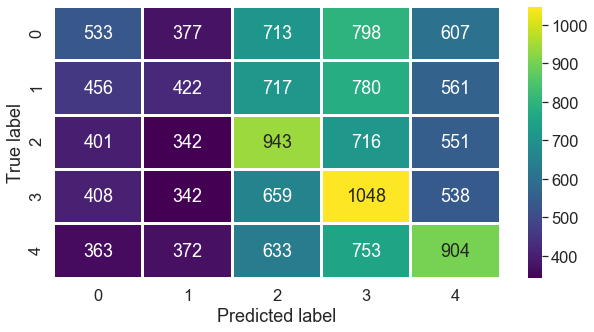

In [90]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [91]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.25      0.18      0.21      3028
           1       0.23      0.14      0.18      2936
           2       0.26      0.32      0.28      2953
           3       0.26      0.35      0.30      2995
           4       0.29      0.30      0.29      3025

    accuracy                           0.26     14937
   macro avg       0.25      0.26      0.25     14937
weighted avg       0.25      0.26      0.25     14937



### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [92]:
X.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period'],
      dtype='object')

In [93]:
xgbmodel.get_booster().feature_names = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea','ResidFAR', 'RetailArea', 'Age', 'Period']

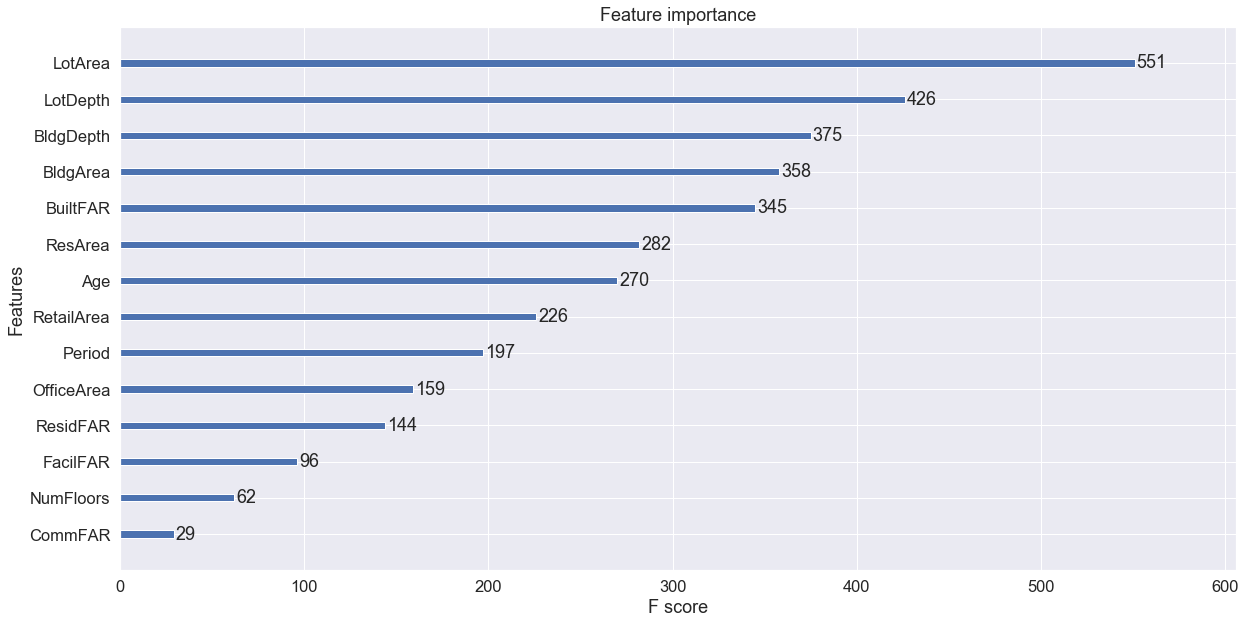

In [94]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

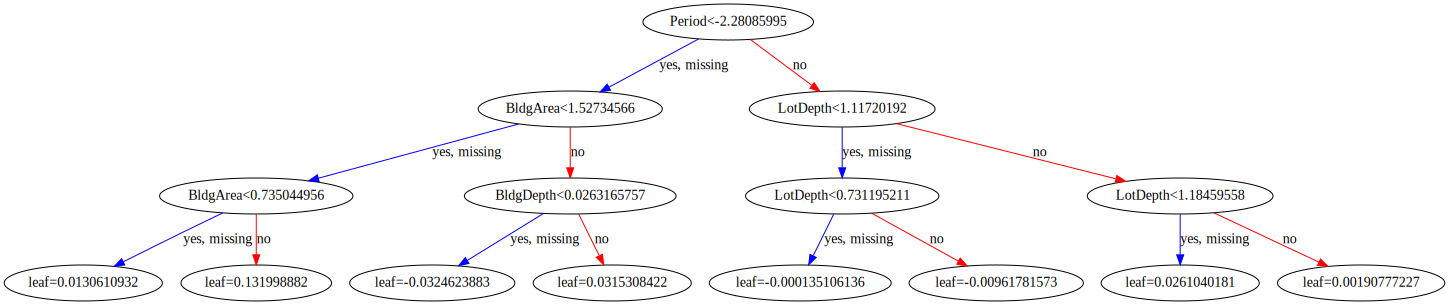

In [95]:
xgb.to_graphviz(xgbmodel,num_trees=110)

### Cross-Validation

In [ ]:
# cv = cross_val_score(xgbmodel,X_train_scaled,y_train,cv=5,verbose=1,scoring='accuracy')

In [ ]:
# cv.mean()

### Using XGBoost (API)

{'subsample': 0.5,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning rate': 0.22999999999999998,
 'gamma': 0,
 'colsample_bytree': 0.5}

In [96]:
dtrain = xgb.DMatrix(data=X_train_scaled,label=y_train)
dtest = xgb.DMatrix(data=X_test_scaled,label=y_test)

In [97]:
params = {'n_estimators': 500,
          'learning_rate': 0.22999999999999998,
          'max_depth': 8,
          'min_child_weight': 1,
          'objective': 'multi:softmax',
          'num_class': 5 ,
          'seed': 0,
          'colsample_bytree': 0.5,
          'eval_metric':'merror'}

In [100]:
xgbmodel = xgb.train(params=params,dtrain=dtrain,num_boost_round=500,evals=[(dtest,"Test")],
                     early_stopping_rounds=10)

[0]	Test-merror:0.75959
Will train until Test-merror hasn't improved in 10 rounds.
[1]	Test-merror:0.745598
[2]	Test-merror:0.737832
[3]	Test-merror:0.719957
[4]	Test-merror:0.705563
[5]	Test-merror:0.697597
[6]	Test-merror:0.696124
[7]	Test-merror:0.693446
[8]	Test-merror:0.684073
[9]	Test-merror:0.678717
[10]	Test-merror:0.675905
[11]	Test-merror:0.672759
[12]	Test-merror:0.670817
[13]	Test-merror:0.668206
[14]	Test-merror:0.660441
[15]	Test-merror:0.654014
[16]	Test-merror:0.653679
[17]	Test-merror:0.651603
[18]	Test-merror:0.649997
[19]	Test-merror:0.644105
[20]	Test-merror:0.637344
[21]	Test-merror:0.636875
[22]	Test-merror:0.632858
[23]	Test-merror:0.631854
[24]	Test-merror:0.631251
[25]	Test-merror:0.629444
[26]	Test-merror:0.623151
[27]	Test-merror:0.62074
[28]	Test-merror:0.620205
[29]	Test-merror:0.614313
[30]	Test-merror:0.608623
[31]	Test-merror:0.607217
[32]	Test-merror:0.604405
[33]	Test-merror:0.601192
[34]	Test-merror:0.598715
[35]	Test-merror:0.598447
[36]	Test-merror:

[307]	Test-merror:0.40885
[308]	Test-merror:0.409051
[309]	Test-merror:0.407779
[310]	Test-merror:0.407913
[311]	Test-merror:0.407645
[312]	Test-merror:0.407445
[313]	Test-merror:0.407512
[314]	Test-merror:0.40711
[315]	Test-merror:0.406574
[316]	Test-merror:0.405905
[317]	Test-merror:0.406039
[318]	Test-merror:0.406373
[319]	Test-merror:0.405101
[320]	Test-merror:0.404767
[321]	Test-merror:0.404298
[322]	Test-merror:0.403562
[323]	Test-merror:0.403428
[324]	Test-merror:0.403026
[325]	Test-merror:0.403294
[326]	Test-merror:0.403227
[327]	Test-merror:0.403026
[328]	Test-merror:0.402758
[329]	Test-merror:0.40229
[330]	Test-merror:0.402156
[331]	Test-merror:0.402022
[332]	Test-merror:0.40162
[333]	Test-merror:0.40162
[334]	Test-merror:0.401888
[335]	Test-merror:0.402022
[336]	Test-merror:0.402022
[337]	Test-merror:0.401754
[338]	Test-merror:0.401352
[339]	Test-merror:0.401085
[340]	Test-merror:0.400884
[341]	Test-merror:0.400482
[342]	Test-merror:0.400214
[343]	Test-merror:0.399679
[344]	

In [101]:
y_pred = xgbmodel.predict(dtest)

In [102]:
y_pred

array([2., 0., 2., ..., 4., 4., 4.], dtype=float32)

### Cross-Validation (API)

In [ ]:
# cv = xgb.cv(params=params,
#             dtrain=dtrain,
#             num_boost_round=100,
#             nfold=5,
#             stratified=False,
#             folds=None,
#             metrics=('merror'),
#             obj=None,
#             feval=None,
#             maximize=False,
#             early_stopping_rounds=10,
#             fpreproc=None,
#             as_pandas=True,
#             verbose_eval=None,
#             show_stdv=True,
#             seed=0,
#             callbacks=None,
#             shuffle=True,)

In [ ]:
# cv

In [ ]:
# cv['test-merror-mean'].min()

### Model Evaluation

In [103]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[ 936,  816,  451,  435,  390],
       [ 712, 1180,  372,  380,  292],
       [ 208,  218, 2191,  174,  162],
       [ 193,  173,  169, 2284,  176],
       [ 123,  130,  138,  175, 2459]], dtype=int64)

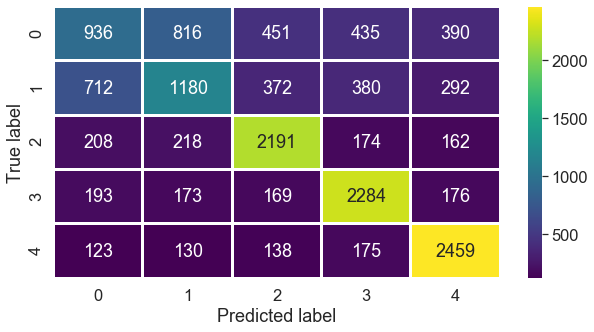

In [104]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [105]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.43      0.31      0.36      3028
           1       0.47      0.40      0.43      2936
           2       0.66      0.74      0.70      2953
           3       0.66      0.76      0.71      2995
           4       0.71      0.81      0.76      3025

    accuracy                           0.61     14937
   macro avg       0.59      0.61      0.59     14937
weighted avg       0.59      0.61      0.59     14937



### Model Tuning

### Using RandomSearchCV

In [57]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='multi:softmax')

In [58]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [59]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='accuracy')

In [60]:
randm.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scal...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [61]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning rate=0.2, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=None, n_estimators=900,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7999999999999999,
              verbosity=1)

In [62]:
randm.best_score_

0.627821681864235

In [63]:
randm.best_params_

{'subsample': 0.7999999999999999,
 'n_estimators': 900,
 'min_child_weight': 2,
 'max_depth': 4,
 'learning rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.5}

{'subsample': 0.5,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning rate': 0.22999999999999998,
 'gamma': 0,
 'colsample_bytree': 0.5}

### Save the Model

In [106]:
filename = 'modelbronx.sav'
dump(xgbmodel,open(filename,'wb'))